Analytical basetable is composed of the population, the candidate predictors and the target

Population is a group of people or objects you want to make a prediction for (eg: donors). There is one row for each object of the population

The candidate predictors describes the objects and the populations. Information can be used to predict events. Age, gender or previous gifts can be used to predict whether someone who will donate for future projects

The target is an information about event to predict. 1 means that the event occurs and O otherwise. The target is whether the donor donated for a historical event 


In [1]:
import sys
import pandas as pd
from pandas     import DataFrame
import numpy as np
import datetime as dt
from datetime import date 
import re

from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from scipy.stats.mstats import winsorize
from numpy                import array
from numpy                import random
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics      import auc
from sklearn.metrics      import roc_auc_score
from matplotlib           import pyplot
from scipy.stats          import pearsonr
import warnings
warnings.filterwarnings('ignore')
import scikitplot as skplt

from sklearn.linear_model   import LogisticRegression
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.metrics        import accuracy_score
from sklearn.metrics        import auc
from sklearn.metrics        import roc_auc_score
from matplotlib             import pyplot as plt

In [2]:
campaigns = pd.read_csv('campaigns.csv', sep=";")
campaigns.head()

,campaignID,date,lettersSent,CostUnit
0,153,13/12/2004,6 873,"0,17 €"
1,154,01/01/2005,7 656,"0,30 €"
2,180,18/01/2005,9 933,"0,20 €"
3,433,29/01/2005,7 448,"0,59 €"
4,476,12/02/2005,6 605,"0,51 €"


In [3]:
len(campaigns)

367

In [4]:
campaign6169 = pd.read_csv('selection campaign 6169.csv')
print(len(campaign6169))
campaign6169.head()

34888


,donorID
0,100001
1,100002
2,100004
3,100008
4,100009


In [5]:
campaign7244 = pd.read_csv('selection campaign 7244.csv')
campaign7244.head()
print(len(campaign7244))
campaign7244[campaign7244['donorID']==48]

25645


,donorID


In [6]:
#population
donors = pd.read_csv('donors.csv', sep=";")
donors.head()

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24
1,100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14
2,100003,1780.0,Flemish Brabant,Flanders,M,NL,1986-12-23
3,100004,1020.0,Brussels,Brussels,F,FR,1952-03-29
4,100005,1020.0,Brussels,Brussels,F,FR,1986-06-25


In [7]:
donors.province.unique()

array(['Flemish Brabant', 'Antwerp', 'Brussels', 'Walloon Brabant',
       'West Flanders', 'East Flanders', 'Liege', 'Luxembourg', 'Namur',
       'Hainaut', 'Limburg', 'Missing'], dtype=object)

In [8]:
donors['dateOfBirth'].isna().sum()

0

In [9]:
print(donors[donors["zipcode"].isnull()])

       donorID  zipcode province   region gender language dateOfBirth
5019    105020      NaN  Missing  Missing      M       EN  1966-11-09
22100   122101      NaN  Missing  Missing      F       EN  1975-10-31


In [10]:
donors["zipcode"].isna().sum()

2

In [11]:
donors = donors.drop([5019, 22100])

In [12]:
donors["zipcode"].isna().sum()

0

In [13]:
donors["province"].isna().sum()

0

In [15]:
donors["region"].isna().sum()

0

In [16]:
population_size = len(donors)
population_size

44689

In [17]:
gifts = pd.read_csv('gifts.csv', sep=";")
gifts.head()

,donorID,campaignID,amount,date
0,100001,NaN,12.39,2004-03-23
1,100001,1577.0,12.39,2007-10-11
2,100001,1634.0,6.69,2007-12-28
3,100001,1778.0,24.79,2008-06-14
4,100001,1808.0,7.44,2008-07-09


In [18]:
gifts["date"] = pd.to_datetime(gifts["date"])
gifts.head()

,donorID,campaignID,amount,date
0,100001,NaN,12.39,2004-03-23
1,100001,1577.0,12.39,2007-10-11
2,100001,1634.0,6.69,2007-12-28
3,100001,1778.0,24.79,2008-06-14
4,100001,1808.0,7.44,2008-07-09


In [19]:
gifts["month"] = gifts["date"].dt.month

In [20]:
gifts.head()

,donorID,campaignID,amount,date,month
0,100001,NaN,12.39,2004-03-23,3
1,100001,1577.0,12.39,2007-10-11,10
2,100001,1634.0,6.69,2007-12-28,12
3,100001,1778.0,24.79,2008-06-14,6
4,100001,1808.0,7.44,2008-07-09,7


In [21]:
gifts.shape

(216594, 5)

In [22]:
gifts = gifts[gifts["campaignID"].notnull()]
gifts.head()

,donorID,campaignID,amount,date,month
1,100001,1577.0,12.39,2007-10-11,10
2,100001,1634.0,6.69,2007-12-28,12
3,100001,1778.0,24.79,2008-06-14,6
4,100001,1808.0,7.44,2008-07-09,7
5,100001,1933.0,24.79,2008-12-01,12


In [23]:
gifts.isna().sum().sum()

0

In [24]:
max(gifts["date"].unique())

numpy.datetime64('2020-01-04T00:00:00.000000000')

In [25]:
min(gifts["date"].unique())

numpy.datetime64('2004-12-18T00:00:00.000000000')

## Target

### -  Target Training set

In [26]:
gifts_target_training = gifts[gifts["campaignID"] == 6169]

print(len(gifts_target_training))


1191


In [27]:
target_training = gifts_target_training.groupby(["donorID"])["amount"].sum().reset_index()
target_training.columns = ["donorID", "amount"]
print(len(target_training))
target_training.head()

1191


,donorID,amount
0,100023,15.0
1,100126,123.0
2,100253,120.0
3,100279,75.0
4,100320,135.0


### - Target Test set

In [28]:
gifts_target_test = gifts[gifts["campaignID"] == 7244]
print(len(gifts_target_test))

361


In [30]:
target_test = gifts_target_test.groupby(["donorID"])["amount"].sum().reset_index()
target_test.columns = ["donorID", "amount"]
print(len(target_test))
target_test.head()

361


,donorID,amount
0,100724,40.0
1,100896,10.0
2,100964,100.0
3,101066,60.0
4,101069,80.0


## Predictive variables

### - Predictive variables training set

In [31]:
reference6169 = dt.datetime(year=2018, month=9, day=4)

gifts_training = gifts[gifts["date"] <= reference6169]

print(len(gifts_training))

193437


In [32]:
basetable_training = gifts_training .groupby(["donorID"])["amount"].agg(['max', 'min','mean','sum', 'count']).reset_index()
basetable_training.head()

,donorID,max,min,mean,sum,count
0,100001,30.00,6.69,15.100000,166.10,11
1,100002,20.00,20.00,20.000000,20.00,1
2,100003,5.00,3.00,3.666667,22.00,6
3,100004,49.58,24.79,27.657200,691.43,25
4,100005,5.00,2.48,3.740000,14.96,4


In [33]:
# Latest gift per donor in 2020
last_gift_training = gifts_training.groupby(["donorID"])["date"].max().reset_index()
last_gift_training["recency_days"] = reference6169 - last_gift_training["date"]   
last_gift_training["recency_days"] = last_gift_training.recency_days.apply(lambda x: x.days)
# Add recency to the basetable
basetable_training = pd.merge(basetable_training, last_gift_training[["donorID", "recency_days"]], how="left")

In [34]:
basetable_training.head()

,donorID,max,min,mean,sum,count,recency_days
0,100001,30.00,6.69,15.100000,166.10,11,2440
1,100002,20.00,20.00,20.000000,20.00,1,1333
2,100003,5.00,3.00,3.666667,22.00,6,0
3,100004,49.58,24.79,27.657200,691.43,25,2650
4,100005,5.00,2.48,3.740000,14.96,4,77


In [35]:
reference = dt.datetime(2018, 9, 4)
reference1 = dt.datetime(2018, 8, 4)

#gifts last month
gifts_last_month6169 = gifts_training[(gifts_training["date"] <= reference) & (gifts_training["date"] >= reference1)]

last_month6169 = gifts_last_month6169.groupby("donorID")["amount"].mean().reset_index()
last_month6169.columns = ["donorID", "last_month_mean"]

basetable_training = pd.merge(basetable_training, last_month6169, how='left', on='donorID')

In [36]:
#Number of gifts in this period per donor
reference = dt.datetime(2018, 9, 4)
reference_y = dt.datetime(2017, 9, 4)

#gifts year 1
gifts_last_year6169 = gifts_training[(gifts_training["date"] <= reference) & (gifts_training["date"] >= reference_y)]

year1_gifts_6169 = gifts_last_year6169.groupby("donorID")["amount"].agg(['mean', 'count']).reset_index()
year1_gifts_6169.columns = ["donorID", "year1_mean", "year1_count"]

basetable_training = pd.merge(basetable_training, year1_gifts_6169, how='left', on='donorID' )


In [37]:
#Number of gifts in this period per donor
reference_y1 = dt.datetime(2017, 9, 4)
reference_y2 = dt.datetime(2016, 9, 4)

#gifts last month
gifts_year2_6169 = gifts_training[(gifts_training["date"] < reference_y1) & (gifts_training["date"] >= reference_y2)]

year2_6169  = gifts_year2_6169.groupby("donorID")["amount"].agg(['mean', 'count']).reset_index()
year2_6169 .columns = ["donorID", "year2_mean", "year2_count"]

basetable_training = pd.merge(basetable_training, year2_6169, how='left', on='donorID' )
basetable_training.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count
0,100001,30.00,6.69,15.100000,166.10,11,2440,NaN,NaN,NaN,NaN,NaN
1,100002,20.00,20.00,20.000000,20.00,1,1333,NaN,NaN,NaN,NaN,NaN
2,100003,5.00,3.00,3.666667,22.00,6,0,4.0,3.5,4.0,4.0,2.0
3,100004,49.58,24.79,27.657200,691.43,25,2650,NaN,NaN,NaN,NaN,NaN
4,100005,5.00,2.48,3.740000,14.96,4,77,NaN,5.0,1.0,5.0,1.0


In [38]:
basetable_training["ratio_month_year"] = basetable_training["last_month_mean"] / basetable_training["year1_mean"]
basetable_training["ratio_year2year_mean"] = basetable_training["year1_mean"] / basetable_training["year2_mean"]
basetable_training["ratio_year2year_count"] = basetable_training["year1_count"] / basetable_training["year2_count"]
basetable_training 

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count,ratio_month_year,ratio_year2year_mean,ratio_year2year_count
0,100001,30.00,6.69,15.100000,166.10,11,2440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,20.00,20.00,20.000000,20.00,1,1333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,5.00,3.00,3.666667,22.00,6,0,4.0,3.5,4.0,4.0,2.0,1.142857,0.875,2.0
3,100004,49.58,24.79,27.657200,691.43,25,2650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,5.00,2.48,3.740000,14.96,4,77,NaN,5.0,1.0,5.0,1.0,NaN,1.000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43364,144687,10.00,10.00,10.000000,10.00,1,1033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43365,144688,15.00,2.48,7.260000,43.56,6,404,NaN,NaN,NaN,15.0,1.0,NaN,NaN,NaN
43366,144689,100.00,24.79,62.395000,124.79,2,71,NaN,100.0,1.0,NaN,NaN,NaN,NaN,NaN
43367,144690,40.00,40.00,40.000000,40.00,1,1344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
basetable_training.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count,ratio_month_year,ratio_year2year_mean,ratio_year2year_count
0,100001,30.00,6.69,15.100000,166.10,11,2440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,20.00,20.00,20.000000,20.00,1,1333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,5.00,3.00,3.666667,22.00,6,0,4.0,3.5,4.0,4.0,2.0,1.142857,0.875,2.0
3,100004,49.58,24.79,27.657200,691.43,25,2650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,5.00,2.48,3.740000,14.96,4,77,NaN,5.0,1.0,5.0,1.0,NaN,1.000,1.0


In [40]:
basetable_training['segment'] = ''

for i in range(len(basetable_training)):
    if (basetable_training['mean'][i] > 1.5*(gifts_training["amount"].mean())) & (basetable_training['count'][i]>=5):
        basetable_training['segment'][i] = 'Gold'
    elif (basetable_training['mean'][i] >= (gifts_training["amount"].mean())) & (basetable_training['count'][i]>=3):
        basetable_training['segment'][i] = 'Silver'
    elif (basetable_training['mean'][i] > 0.5*(gifts_training["amount"].mean())) & (basetable_training['count'][i]>=3):
        basetable_training['segment'][i] = 'Bronze'
    else:
        basetable_training['segment'][i] = 'Regular'

In [41]:
donors["dateOfBirth"] = pd.to_datetime(donors["dateOfBirth"])

In [42]:
#calculate age training basetable
donors['age_6169'] = (reference6169 - donors['dateOfBirth'])
donors['age_6169'] = donors.age_6169.apply(lambda x: x.days)
donors['age_6169'] = round((donors['age_6169']/365),1)
donors.head(2)

,donorID,zipcode,province,region,gender,language,dateOfBirth,age_6169
0,100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,50.7
1,100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14,66.7


In [43]:
basetable_training = pd.merge(basetable_training,donors[["donorID","age_6169","gender","province", "language"]], on = "donorID", how = "left")

basetable_training.head(2)

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count,ratio_month_year,ratio_year2year_mean,ratio_year2year_count,segment,age_6169,gender,province,language
0,100001,30.0,6.69,15.1,166.1,11,2440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,50.7,F,Flemish Brabant,NL
1,100002,20.0,20.00,20.0,20.0,1,1333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,66.7,M,Antwerp,NL


#### Merge data set with campaign 6169 selection

In [44]:
basetable_training = pd.merge(campaign6169, basetable_training, on = "donorID", how = "left")
print(len(basetable_training))
basetable_training.head(2)

34888


,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count,ratio_month_year,ratio_year2year_mean,ratio_year2year_count,segment,age_6169,gender,province,language
0,100001,30.0,6.69,15.1,166.1,11.0,2440.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,50.7,F,Flemish Brabant,NL
1,100002,20.0,20.00,20.0,20.0,1.0,1333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,66.7,M,Antwerp,NL


#### Create dummies variables

In [45]:
#Dummy variables for province
dummies_province = pd.get_dummies(basetable_training["province"], drop_first=True, dummy_na=True)
dummies_province .head()

,Brussels,East Flanders,Flemish Brabant,Hainaut,Liege,Limburg,Luxembourg,Namur,Walloon Brabant,West Flanders,NaN
0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0


In [46]:
#Change dummy variable name
dummies_province.columns = ['prov_Br', 'prov_EaF', 'prov_FB', 'prov_Ha', 'prov_Liege', 'prov_Lim', 'prov_Lux', 'prov_Na','prov_WaB', 'prov_WeF', 'prov_NaN']
# Add the dummy variable to the basetable
basetable_training = pd.concat([basetable_training, dummies_province], axis=1)
# Delete the original variable from the basetable
del basetable_training["province"]

In [47]:
basetable_training.language.isna().sum()

1113

In [48]:
#Dummy variables for language
dummies_language_training = pd.get_dummies(basetable_training["language"], drop_first=True, dummy_na=True)
dummies_language_training.head()

,FR,NL,NaN
0,0,1,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


In [49]:
#Change dummy variable name
dummies_language_training.columns = ['language_x', 'language_y', 'language_NaN']
# Add the dummy variable to the basetable
basetable_training = pd.concat([basetable_training, dummies_language_training], axis=1)
# Delete the original variable from the basetable
del basetable_training["language"]

In [50]:
#Dummy variables for segment
dummies_segment_training = pd.get_dummies(basetable_training["segment"], drop_first=True)
dummies_segment_training.head()

,Gold,Regular,Silver
0,0,1,0
1,0,1,0
2,0,0,0
3,0,0,1
4,0,1,0


In [51]:
#Change dummy variable name
dummies_segment_training.columns = ['segment_x', 'segment_y', 'segment_z']
# Add the dummy variable to the basetable
basetable_training = pd.concat([basetable_training, dummies_segment_training], axis=1)
# Delete the original variable from the basetable
del basetable_training["segment"]

In [52]:
basetable_training.gender.isna().sum()

1132

In [53]:
# Create the dummy variable gender
dummies_gender_training = pd.get_dummies(basetable_training["gender"], drop_first=True, dummy_na=True)
dummies_gender_training.head()

,M,NaN
0,0,0
1,1,0
2,0,0
3,1,0
4,1,0


In [54]:
#Change dummy variable name
dummies_gender_training.columns = ['gender_x', 'gender_y']
# Add the dummy variable to the basetable
basetable_training = pd.concat([basetable_training, dummies_gender_training], axis=1)
# Delete the original variable from the basetable
del basetable_training["gender"]

In [55]:
basetable_training.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,...,prov_WeF,prov_NaN,language_x,language_y,language_NaN,segment_x,segment_y,segment_z,gender_x,gender_y
0,100001,30.00,6.69,15.100000,166.10,11.0,2440.0,NaN,NaN,NaN,...,0,0,0,1,0,0,1,0,0,0
1,100002,20.00,20.00,20.000000,20.00,1.0,1333.0,NaN,NaN,NaN,...,0,0,0,1,0,0,1,0,1,0
2,100004,49.58,24.79,27.657200,691.43,25.0,2650.0,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
3,100008,50.00,24.79,41.456667,124.37,3.0,2503.0,NaN,NaN,NaN,...,0,0,1,0,0,0,0,1,1,0
4,100009,25.00,7.44,17.198947,326.78,19.0,2354.0,NaN,NaN,NaN,...,0,0,1,0,0,0,1,0,1,0


#### - Replace missing values

In [56]:
#replace missing values by 0

basetable_training["last_month_mean"] = basetable_training["last_month_mean"].replace(np.nan, 0)
basetable_training["count"] = basetable_training["count"].replace(np.nan, 0)
basetable_training["year1_mean"] = basetable_training["year1_mean"].replace(np.nan, 0)
basetable_training["year1_count"] = basetable_training["year1_count"].replace(np.nan, 0)
basetable_training["year2_mean"] = basetable_training["year2_mean"].replace(np.nan, 0)
basetable_training["year2_count"] = basetable_training["year2_count"].replace(np.nan, 0)
basetable_training["ratio_month_year"] = basetable_training["ratio_month_year"].replace(np.nan, 0)
basetable_training["ratio_year2year_mean"] = basetable_training["ratio_year2year_mean"].replace(np.nan, 0)
basetable_training["ratio_year2year_count"] = basetable_training["ratio_year2year_count"].replace(np.nan, 0)


# There are missing values in the variable Age. We replace it by the median age of donors
#for n in basetable_training['age_6169']:
 #   if basetable_training['age_6169'].isna().sum() > 0:
  #      basetable_training[basetable_training['age_6169'].isna()] = basetable_training['age_6169'].median()

In [57]:
basetable_training['age_NaN'] = basetable_training['age_6169'].isna()*1

In [58]:
basetable_training['age_NaN'].sum()

1113

In [59]:
basetable_training["age_6169"].median()

47.3

In [60]:
basetable_training["age_6169"] = basetable_training["age_6169"].replace(np.nan, basetable_training["age_6169"].median())


In [61]:
basetable_training["age_6169"].isna().sum()

0

In [62]:
basetable_training["recency_days"].isna().sum()

1111

In [63]:
basetable_training["recency_days_NaN"] = basetable_training["recency_days"].isna()*1

In [64]:
basetable_training["recency_days_NaN"].sum()

1111

In [65]:
basetable_training["recency_days"] = basetable_training["recency_days"].replace(np.nan, basetable_training["recency_days"].median())

In [66]:
basetable_training["recency_days"].isna().sum()

0

In [67]:
basetable_training.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,...,language_x,language_y,language_NaN,segment_x,segment_y,segment_z,gender_x,gender_y,age_NaN,recency_days_NaN
0,100001,30.00,6.69,15.100000,166.10,11.0,2440.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,0
1,100002,20.00,20.00,20.000000,20.00,1.0,1333.0,0.0,0.0,0.0,...,0,1,0,0,1,0,1,0,0,0
2,100004,49.58,24.79,27.657200,691.43,25.0,2650.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
3,100008,50.00,24.79,41.456667,124.37,3.0,2503.0,0.0,0.0,0.0,...,1,0,0,0,0,1,1,0,0,0
4,100009,25.00,7.44,17.198947,326.78,19.0,2354.0,0.0,0.0,0.0,...,1,0,0,0,1,0,1,0,0,0


#### Dealing with outliers

In [68]:

# Show the maximum age 

print(basetable_training["age_6169"].max())
print(basetable_training["age_6169"].min())

129.3
20.2


In [69]:
#Dealing with outliers in the variable age

# Calculate mean and standard deviation of age
mean_age6169 = basetable_training["age_6169"].mean()
std_age6169 = basetable_training["age_6169"].std()

# Calculate the lower and upper limits
lower_limit6169 = mean_age6169 - std_age6169 * 3
upper_limit6169 = mean_age6169 + std_age6169 * 3

# Add a variable age_no_outliers to the basetable with outliers replaced
basetable_training["age_no_outliers"] = (pd.Series([min(max(a, lower_limit6169), upper_limit6169) 
                             for a in basetable_training["age_6169"]]))
print(basetable_training["age_no_outliers"].max())

96.02013507694956


In [70]:
#Delete previous age columns
del basetable_training["age_6169"]

In [71]:
# Check minimum and max mean of donations
print(basetable_training["mean"].min())
print(basetable_training["mean"].max())


1.3
2479000.0


In [72]:
# Fill out the lower limit
lower_limit6169 = 0.0

# Winsorize the variable sum_donations
basetable_training["mean"] = winsorize(basetable_training["mean"], limits=[lower_limit6169, 0.04])

# Check maximum sum of donations after winsorization
print(basetable_training["mean"].max())

123.95


In [73]:
# Check minimum, maximum sum of donations
print(basetable_training["sum"].min())
print(basetable_training["sum"].max())

1.3
2479000.0


In [74]:
# Fill out the lower limit
lower_limit6169 = 0.0

# Winsorize the variable sum_donations
basetable_training["sum"] = winsorize(basetable_training["sum"], limits=[lower_limit6169, 0.04])

# Check maximum sum of donations after winsorization
print(basetable_training["sum"].max())

998.95


In [75]:
# Check min and max of min amount of donations per donors
print(basetable_training["min"].min())
print(basetable_training["min"].max())

0.1
2479000.0


In [76]:
# Fill out the lower limit
lower_limit6169 = 0.0

# Winsorize the variable sum_donations
basetable_training["min"] = winsorize(basetable_training["min"], limits=[lower_limit6169, 0.04])

# Check maximum sum of donations after winsorization
print(basetable_training["min"].max())

100.0


In [77]:
# Check min and max of max amount of donations per donors
print(basetable_training["max"].min())
print(basetable_training["max"].max())

1.3
2479000.0


In [78]:
# Fill out the lower limit
lower_limit6169 = 0.0

# Winsorize the variable sum_donations
basetable_training["max"] = winsorize(basetable_training["max"], limits=[lower_limit6169, 0.04])

# Check maximum sum of donations after winsorization
print(basetable_training["max"].max())

200.0


#### ADD target variables to the base table

In [79]:
#derive targets and add to the basetables

target = list(target_training["donorID"][target_training["amount"] > 0])

basetable_training["target"] = pd.Series([1 if donorID in target else 0 for donorID in basetable_training["donorID"]])
basetable_training.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,...,language_NaN,segment_x,segment_y,segment_z,gender_x,gender_y,age_NaN,recency_days_NaN,age_no_outliers,target
0,100001,30.00,6.69,15.100000,166.10,11.0,2440.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,50.7,0
1,100002,20.00,20.00,20.000000,20.00,1.0,1333.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,0,66.7,0
2,100004,49.58,24.79,27.657200,691.43,25.0,2650.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,66.5,0
3,100008,50.00,24.79,41.456667,124.37,3.0,2503.0,0.0,0.0,0.0,...,0,0,0,1,1,0,0,0,81.1,0
4,100009,25.00,7.44,17.198947,326.78,19.0,2354.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,0,86.7,0


In [233]:
basetable_training.columns

Index(['donorID', 'max', 'min', 'mean', 'sum', 'count', 'recency_days',
       'last_month_mean', 'year1_mean', 'year1_count', 'year2_mean',
       'year2_count', 'ratio_month_year', 'ratio_year2year_mean',
       'ratio_year2year_count', 'prov_Br', 'prov_EaF', 'prov_FB', 'prov_Ha',
       'prov_Liege', 'prov_Lim', 'prov_Lux', 'prov_Na', 'prov_WaB', 'prov_WeF',
       'prov_NaN', 'language_x', 'language_y', 'language_NaN', 'segment_x',
       'segment_y', 'segment_z', 'gender_x', 'gender_y', 'age_NaN',
       'recency_days_NaN', 'age_no_outliers', 'target', 'proba_stepwise'],
      dtype='object')

In [80]:
# Target incidences
print(round(sum(basetable_training["target"]) / len(basetable_training), 3))


0.034


In [81]:

basetable_training.isna().sum().sum()


0

In [82]:
basetable_training.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,...,language_NaN,segment_x,segment_y,segment_z,gender_x,gender_y,age_NaN,recency_days_NaN,age_no_outliers,target
0,100001,30.00,6.69,15.100000,166.10,11.0,2440.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,50.7,0
1,100002,20.00,20.00,20.000000,20.00,1.0,1333.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,0,66.7,0
2,100004,49.58,24.79,27.657200,691.43,25.0,2650.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,66.5,0
3,100008,50.00,24.79,41.456667,124.37,3.0,2503.0,0.0,0.0,0.0,...,0,0,0,1,1,0,0,0,81.1,0
4,100009,25.00,7.44,17.198947,326.78,19.0,2354.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,0,86.7,0


### Variable selection

In [141]:
selectedFeatures = []
target = "target"

for column in basetable_training.columns:
    if column not in ("donorID","target"):
       # (pearson,pvalue) = pearsonr(basetable_training[column],basetable_training[target])
        #print(f"{column} - p-vlue = {pvalue} - selected : {1 if pvalue < 0.001 else 0}")
        #if pvalue < 0.001:
            selectedFeatures.append(column)

In [142]:
basetable_training.columns

Index(['donorID', 'max', 'min', 'mean', 'sum', 'count', 'recency_days',
       'last_month_mean', 'year1_mean', 'year1_count', 'year2_mean',
       'year2_count', 'ratio_month_year', 'ratio_year2year_mean',
       'ratio_year2year_count', 'prov_Br', 'prov_EaF', 'prov_FB', 'prov_Ha',
       'prov_Liege', 'prov_Lim', 'prov_Lux', 'prov_Na', 'prov_WaB', 'prov_WeF',
       'prov_NaN', 'language_x', 'language_y', 'language_NaN', 'segment_x',
       'segment_y', 'segment_z', 'gender_x', 'gender_y', 'age_NaN',
       'recency_days_NaN', 'age_no_outliers', 'target'],
      dtype='object')

In [143]:
selectedFeatures

['max',
 'min',
 'mean',
 'sum',
 'count',
 'recency_days',
 'last_month_mean',
 'year1_mean',
 'year1_count',
 'year2_mean',
 'year2_count',
 'ratio_month_year',
 'ratio_year2year_mean',
 'ratio_year2year_count',
 'prov_Br',
 'prov_EaF',
 'prov_FB',
 'prov_Ha',
 'prov_Liege',
 'prov_Lim',
 'prov_Lux',
 'prov_Na',
 'prov_WaB',
 'prov_WeF',
 'prov_NaN',
 'language_x',
 'language_y',
 'language_NaN',
 'segment_x',
 'segment_y',
 'segment_z',
 'gender_x',
 'gender_y',
 'age_NaN',
 'recency_days_NaN',
 'age_no_outliers']

In [144]:
target = "target"

In [145]:
def stepwiseRegresion (trainingSet: DataFrame, testSet: DataFrame, selectedFeatures: [str], target: [str]) -> DataFrame:

    def computeAUC (forFeatures: [str]) -> ([str],float,float):
    
        model.fit(trainingSet[forFeatures], trainingSet[target])

        trainingSet["proba_stepwise"] = DataFrame(model.predict_proba(trainingSet[forFeatures]))[1]
        testSet["proba_stepwise"]     = DataFrame(model.predict_proba(testSet[forFeatures]))[1]

        aucTraining = roc_auc_score(array(trainingSet[target]),array(trainingSet["proba_stepwise"]))
        aucTest     = roc_auc_score(array(testSet[target]),array(testSet["proba_stepwise"]))

        trainingSet.drop("proba_stepwise", axis = 1)
        testSet.drop("proba_stepwise", axis = 1)

        return (forFeatures,aucTraining,aucTest)

    featuresOrder = []
    forwardSelection = []

    for step in range(len(selectedFeatures)):
        print(f"step {step+1}")
        aucs = []
        for feature in selectedFeatures:
            if feature not in featuresOrder:
                modelFeatures = featuresOrder.copy()
                modelFeatures.append(feature)
                aucs.append(computeAUC(forFeatures = modelFeatures))

        steps = DataFrame(aucs)
        steps.columns = ["Feature","AUC training", "AUC test"]
        steps = steps.sort_values(by=["AUC test"], ascending = False)

        featuresOrder = steps["Feature"].iloc[0]
        forwardSelection.append((step+1, steps["Feature"].iloc[0],steps["AUC training"].iloc[0],steps["AUC test"].iloc[0]))

    df = DataFrame(forwardSelection)
    df.columns = ("Step","Features","AUC Train","AUC Test")
    
    return df

In [146]:
model = GradientBoostingClassifier()

In [147]:

forwardSelection = stepwiseRegresion(trainingSet      = basetable_training, 
                                     testSet          = basetable_test,
                                     selectedFeatures = selectedFeatures,
                                     target           = target)


step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36


In [185]:
forwardSelection


,Step,Features,AUC Train,AUC Test
0,1,[min],0.989606,0.738417
1,2,"[min, segment_z]",0.991092,0.796775
2,3,"[min, segment_z, prov_Ha]",0.991532,0.799005
3,4,"[min, segment_z, prov_Ha, recency_days_NaN]",0.991607,0.799057
4,5,"[min, segment_z, prov_Ha, recency_days_NaN, pr...",0.991642,0.799058
5,6,"[min, segment_z, prov_Ha, recency_days_NaN, pr...",0.991642,0.799058
6,7,"[min, segment_z, prov_Ha, recency_days_NaN, pr...",0.991649,0.799059
7,8,"[min, segment_z, prov_Ha, recency_days_NaN, pr...",0.991649,0.799059
8,9,"[min, segment_z, prov_Ha, recency_days_NaN, pr...",0.991649,0.799059
9,10,"[min, segment_z, prov_Ha, recency_days_NaN, pr...",0.991649,0.799059


In [221]:
#selectedpredictors
selectedpredictors = forwardSelection['Features'][6]
selectedpredictors

['min',
 'segment_z',
 'prov_Ha',
 'recency_days_NaN',
 'prov_Br',
 'prov_Lim',
 'prov_Lux']

In [222]:
['gender_x','recency_days','year2_count','language_x','Region_x','Region_y']

['gender_x',
 'recency_days',
 'year2_count',
 'language_x',
 'Region_x',
 'Region_y']

In [223]:
features = selectedpredictors

target   = "target"

In [224]:
tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 1000)
randomForest = RandomForestClassifier(n_estimators = 100)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

In [225]:
models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "svm"          :svm,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors
         }

### Train the model on the training set

In [226]:
for model in models:
    models[model].fit(basetable_training[features],basetable_training[target])
    print(f"{model} has been trained successfully")

tree has been trained successfully
logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
svm has been trained successfully
neuralNet has been trained successfully
neighbors has been trained successfully


### Evaluate the model

In [227]:
performances = {}

for model in models:
    predictions   = models[model].predict(basetable_training[features])
    probabilities = DataFrame(models[model].predict_proba(basetable_training[features]))[1]
    accuracy      = accuracy_score(basetable_training[target],predictions)
    auc           = roc_auc_score(array(basetable_training[target]),array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

In [228]:
DataFrame(performances)

,tree,logistic,randomForest,boostedTree,svm,neuralNet,neighbors
Accuracy,0.993637,0.965862,0.993637,0.990226,0.965862,0.965862,0.990570
AUC,0.997762,0.540864,0.997417,0.991649,0.354047,0.663872,0.980593


In [229]:
def auc (variables, target, basetable_training):
    X = basetable_training[variables]
    y = basetable_training[target]
    logreg = linear_model.LogisticRegression()
    logreg.fit(X,y)
    predictions = logreg.predict_proba(X)[:,1]
    auc = roc_auc_score(y, predictions)
    return(auc)

auc = auc(["age_no_outliers", "gender_x"],["target"], basetable_training)
print(round(auc, 2))

0.7


In [176]:
def next_best(current_variables, candidate_variables, target, basetable_training):
    best_auc = -1
    best_variable = None
    for v in candidate_variables:
        auc_v = auc(current_variables + [v], target, basetable_training)
        if auc_v >= best_auc:
            best_auc = auc_v
            best_variable = v 
    return best_variable 


In [178]:
current_variables = ["age_no_outliers", "gender_x"]
candidate_variables = ["mean", "min", "max", "age_no_outliers", "gender_x", "region_x", "region_y", "sum"]

print(next_best)

<function next_best at 0x0000024F33088280>


In [174]:

next_variable = next_best(current_variables, candidate_variables, target, basetable_training)
next_variable


candidate_variables = ["mean", "min", "max", "age_no_outliers", "gender_x", "region_x", "region_y", "sum"]

current_variable = ["gender_x", "age_no_outliers"]

target = ["target"]
max_number_variables = 5
number_iterations = min(max_number_variables, len(candidate_variables))

for i in range(0, number_iterations):
    next_var = next_best(current_variables, candidate_variables, target, basetable_training)
    current_variables = current_variables + [next_variable]
    candidate_variables.remove(next_variable)
print(current_variables)

TypeError: 'numpy.float64' object is not callable

In [166]:
basetable_training['age_no_outliers'] = pd.to_numeric(basetable_training['age_no_outliers'])

In [232]:
features = basetable_test[['gender_x','recency_days','year2_count','language_x','Region_x','Region_y']]
target   = basetable_test["target"]

X = features
y = target

logreg = linear_model.LogisticRegression(solver = "lbfgs", max_iter = 1000)

logreg.fit(X,y)

predictions = logreg.predict_proba(X)

skplt.metrics.plot_cumulative_gain(y, predictions, figsize=(10,5), title_fontsize=15, text_fontsize=15)
plt.show()

KeyError: "['Region_x', 'Region_y'] not in index"

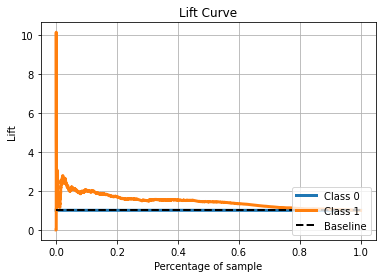

In [218]:
skplt.metrics.plot_lift_curve(y, predictions)
plt.show()

In [202]:
sys.path.append(r"C:\Users\mobama\OneDrive - IESEG\Predictive and descriptive analysis\Predictive modeling-20201207\Notebooks")

In [213]:
from ieseg import partition
from ieseg import roc
from ieseg import lift
from ieseg import cumulativeResponse
from ieseg import cumulativeGains

In [220]:
lifts     = {}
responses = {}
gains     = {}
data      = DataFrame(basetable_training[target]).copy() 

for (index,model) in enumerate(models):
    data[f"proba {model}"] = DataFrame(models[model].predict_proba(basetable_training[features]))[1]
    lifts[model] = lift(dataSet = data, actuals = "target", probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = "target", probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = "target", probability = "proba "+str(model))
            

KeyError: "None of [Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\n            ...\n            0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\n           dtype='int64', length=25645)] are in the [columns]"

In [206]:
data.head(20)

,target,proba tree,proba logistic,proba randomForest,proba boostedTree,proba svm,proba neuralNet,proba neighbors
0,0,0.0,0.033796,0.019158,0.017397,0.032423,0.126817,0.0
1,0,0.0,0.032975,0.000000,0.004268,0.045089,0.013763,0.0
2,0,0.0,0.024025,0.000000,0.003970,0.052569,0.006083,0.0
3,0,0.0,0.086658,0.000000,0.003929,0.056120,0.023638,0.0
4,0,0.0,0.024814,0.000000,0.017397,0.031737,0.055680,0.0
5,0,0.0,0.023353,0.000000,0.014602,0.029589,0.017775,0.0
6,0,0.0,0.020877,0.000000,0.027781,0.051782,0.013475,0.0
7,0,0.0,0.024927,0.000000,0.005478,0.036900,0.016464,0.0
8,0,0.0,0.023793,0.000000,0.004028,0.047303,0.004682,0.0
9,0,0.0,0.032371,0.000000,0.004028,0.044207,0.013865,0.0


In [207]:
lifts["logistic"].head(20)

,Quantile,Lift,Base
14,1.00,2.113590,1.0
13,0.95,1.116522,1.0
12,0.90,1.245308,1.0
11,0.85,1.205227,1.0
10,0.75,1.037730,1.0
9,0.65,1.277258,1.0
8,0.60,1.367877,1.0
7,0.55,1.009868,1.0
6,0.40,0.974061,1.0
5,0.35,0.841148,1.0


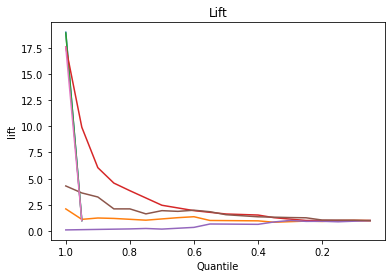

In [208]:
for model in models:
    pyplot.plot(lifts[model]["Quantile"], lifts[model]["Lift"])
    pyplot.gca().invert_xaxis()
    pyplot.xlabel("Quantile")
    pyplot.ylabel("lift")
    pyplot.title("Lift")

In [ ]:
population_size = basetable_training.count()
target_incidence = round(sum(basetable_training["target"]) / len(basetable_training), 3))
reward_target = 
cost_campaign = 

def profit (perc_targets, perc_selected, population_size, reward_target, cost_campaign):
    cost = cost_campaign * perc_selected * population_size
    reward = reward_target * perc_targets * perc_selected * population_size
return (reward - cost)

In [ ]:
perc_selected = 
lift = 
perc_targets = lift * target_incidence

print(profit(perc_targets, perc_selected, population_size, reward_target, cost_campaign))

In [ ]:
print(profit(target_incidence, 1, population_size, reward-target, cost_campaign))

In [ ]:
population_size
target_incidence = 
targets_to_reach = 
perc_targets_to_reach = targets_to_reach / (target_incidence * population)

print(perc_targets_to_reach)


In [ ]:
cumulative_gains = 
nb_donors_to_reach = cumulative_gains * population_size


In [222]:
basetable_training

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,...,language_y,language_NaN,segment_x,segment_y,segment_z,gender_x,gender_y,age_no_outliers,target,proba_stepwise
0,100001.0,30.00,6.69,15.100000,166.10,11.0,2440.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,50.7,0,0.000000
1,100002.0,20.00,20.00,20.000000,20.00,1.0,1333.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,66.7,0,0.000000
2,100004.0,49.58,24.79,27.657200,691.43,25.0,2650.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.5,0,0.000000
3,100008.0,50.00,24.79,41.456667,124.37,3.0,2503.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,81.1,0,0.000000
4,100009.0,25.00,7.44,17.198947,326.78,19.0,2354.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,86.7,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34883,144686.0,50.00,50.00,50.000000,50.00,1.0,1225.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,54.0,0,0.083333
34884,144687.0,10.00,10.00,10.000000,10.00,1.0,1033.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,48.0,0,0.000000
34885,144689.0,100.00,24.79,62.395000,124.79,2.0,71.0,0.0,100.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,51.4,0,0.000000
34886,144690.0,40.00,40.00,40.000000,40.00,1.0,1344.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,42.4,0,0.000000


### Evaluate the model on test set

In [688]:
    predictions   = logistic.predict(basetable_test[features])
    probabilities = DataFrame(logistic.predict_proba(basetable_test[features]))[1]
    accuracy      = accuracy_score(basetable_test[target],predictions)
    auc           = roc_auc_score(array(basetable_test[target]),array(probabilities))
    

In [689]:
auc

0.6717704604227828

In [690]:
accuracy

0.9860011698186781

In [691]:
del basetable_test["proba_stepwise"] 

In [692]:
 basetable_test["proba_donation"] = probabilities

In [693]:
 basetable_test.sort_values(by=["proba_donation"])
    

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,...,language_y,language_NaN,segment_x,segment_y,segment_z,gender_x,gender_y,age_no_outliers,target,proba_donation
5877,113466,200.000,100.00,123.950000,495.790,1.0,4371.0,0.0,0.000,0.0,...,0,0,0,1,0,1,0,45.8,0,0.005886
8267,118218,12.390,12.39,12.390000,12.390,1.0,4054.0,0.0,0.000,0.0,...,0,0,0,1,0,1,0,54.8,0,0.006466
8417,118416,24.790,24.79,24.790000,24.790,1.0,4045.0,0.0,0.000,0.0,...,0,0,0,1,0,1,0,80.1,0,0.006483
7780,117411,12.390,12.39,12.390000,24.780,2.0,4037.0,0.0,0.000,0.0,...,0,0,0,1,0,1,0,46.5,0,0.006498
8367,118355,12.390,12.39,12.390000,12.390,1.0,4037.0,0.0,0.000,0.0,...,0,0,0,1,0,1,0,37.0,0,0.006498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7074,115756,13.629,2.20,6.360026,241.681,38.0,112.0,0.0,3.300,1.0,...,1,0,0,1,0,0,0,77.6,1,0.652736
23919,140920,3.500,1.00,3.120000,78.000,25.0,535.0,0.0,0.000,0.0,...,1,0,0,1,0,0,0,67.3,0,0.724146
11934,123409,6.500,1.30,3.254054,120.400,37.0,210.0,0.0,3.125,4.0,...,1,0,0,1,0,0,0,80.4,0,0.743088
17319,131262,9.000,4.29,5.542895,210.630,38.0,128.0,0.0,5.860,3.0,...,1,0,0,1,0,1,0,38.7,1,0.795671


In [670]:
 basetable_test.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,...,language_x,language_y,language_NaN,segment_x,segment_y,segment_z,gender_x,gender_y,age_no_outliers,target
0,100001,30.0,6.69,15.100000,166.10,11.0,2727.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,0,51.5,0
1,100002,20.0,20.00,20.000000,20.00,1.0,1620.0,0.0,0.0,0.0,...,0,1,0,0,1,0,1,0,67.5,0
2,100008,50.0,24.79,41.456667,124.37,3.0,2790.0,0.0,0.0,0.0,...,1,0,0,0,0,1,1,0,81.9,0
3,100009,25.0,7.44,17.198947,326.78,19.0,2641.0,0.0,0.0,0.0,...,1,0,0,0,1,0,1,0,87.5,0
4,100010,40.0,40.00,40.000000,40.00,1.0,1617.0,0.0,0.0,0.0,...,1,0,0,0,1,0,1,0,36.1,0


In [671]:
len( basetable_test)

25645

### -  Predictive variables test set

In [91]:
reference7244 = dt.datetime(year=2019, month=6, day=18)

gifts_test = gifts[gifts["date"] <= reference7244]

print(len(gifts_test))

198934


In [92]:
basetable_test = gifts_test.groupby(["donorID"])["amount"].agg(['max', 'min','mean','sum', 'count']).reset_index()
basetable_test.head()

,donorID,max,min,mean,sum,count
0,100001,30.00,6.69,15.100000,166.10,11
1,100002,20.00,20.00,20.000000,20.00,1
2,100003,5.00,3.00,3.833333,46.00,12
3,100004,49.58,24.79,27.657200,691.43,25
4,100005,10.00,2.48,4.992000,24.96,5


In [93]:
# Latest gift per donor
last_gift_test = gifts_test.groupby(["donorID"])["date"].max().reset_index()
last_gift_test["recency_days"] = reference7244 - last_gift_test["date"]   
last_gift_test["recency_days"] = last_gift_test.recency_days.apply(lambda x: x.days)
# Add recency to the basetable
basetable_test = pd.merge(basetable_test, last_gift_test[["donorID", "recency_days"]], how="left")

In [94]:
basetable_test.head()

,donorID,max,min,mean,sum,count,recency_days
0,100001,30.00,6.69,15.100000,166.10,11,2727
1,100002,20.00,20.00,20.000000,20.00,1,1620
2,100003,5.00,3.00,3.833333,46.00,12,1
3,100004,49.58,24.79,27.657200,691.43,25,2937
4,100005,10.00,2.48,4.992000,24.96,5,61


In [95]:
reference = dt.datetime(2019, 6, 18)
reference1 = dt.datetime(2019, 5, 18)

#gifts last month
gifts_last_month7244 = gifts_test[(gifts_test["date"] <= reference) & (gifts_test["date"] >= reference1)]

last_month7244 = gifts_last_month7244.groupby("donorID")["amount"].mean().reset_index()
last_month7244.columns = ["donorID", "last_month_mean"]

basetable_test = pd.merge(basetable_test, last_month7244, how='left', on='donorID')

In [96]:
#Number of gifts in this period per donor
reference = dt.datetime(2019, 6, 18)
reference_y = dt.datetime(2018, 6, 18)

#gifts last month
gifts_last_year7244 = gifts_test[(gifts_test["date"] <= reference) & (gifts_test["date"] >= reference_y)]

year1_gifts_7244 = gifts_last_year7244.groupby("donorID")["amount"].agg(['mean','count']).reset_index()
year1_gifts_7244.columns = ["donorID", "year1_mean", "year1_count"]

basetable_test = pd.merge(basetable_test, year1_gifts_7244, how='left', on='donorID' )


In [97]:
#Number of gifts in this period per donor
reference_y1 = dt.datetime(2018, 6, 18)
reference_y2 = dt.datetime(2017, 6, 18)

#gifts last month
gifts_last_year7244 = gifts_test[(gifts_test["date"] < reference_y1) & (gifts_test["date"] >= reference_y2)]

year2_gifts_7244 = gifts_last_year7244.groupby("donorID")["amount"].agg(['mean','count']).reset_index()
year2_gifts_7244.columns = ["donorID", "year2_mean", "year2_count"]

basetable_test = pd.merge(basetable_test, year2_gifts_7244, how='left', on='donorID' )
basetable_test.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count
0,100001,30.00,6.69,15.100000,166.10,11,2727,NaN,NaN,NaN,NaN,NaN
1,100002,20.00,20.00,20.000000,20.00,1,1620,NaN,NaN,NaN,NaN,NaN
2,100003,5.00,3.00,3.833333,46.00,12,1,4.0,3.875,8.0,3.75,4.0
3,100004,49.58,24.79,27.657200,691.43,25,2937,NaN,NaN,NaN,NaN,NaN
4,100005,10.00,2.48,4.992000,24.96,5,61,NaN,7.500,2.0,NaN,NaN


In [98]:
basetable_test["ratio_month_year"] = basetable_test["last_month_mean"] / basetable_test["year1_mean"]
basetable_test["ratio_year2year_mean"] = basetable_test["year1_mean"] / basetable_test["year2_mean"]
basetable_test["ratio_year2year_count"] = basetable_test["year1_count"] / basetable_test["year2_count"]


In [99]:
basetable_test.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count,ratio_month_year,ratio_year2year_mean,ratio_year2year_count
0,100001,30.00,6.69,15.100000,166.10,11,2727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,20.00,20.00,20.000000,20.00,1,1620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,5.00,3.00,3.833333,46.00,12,1,4.0,3.875,8.0,3.75,4.0,1.032258,1.033333,2.0
3,100004,49.58,24.79,27.657200,691.43,25,2937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,10.00,2.48,4.992000,24.96,5,61,NaN,7.500,2.0,NaN,NaN,NaN,NaN,NaN


In [100]:
basetable_test['segment'] = ''

for i in range(len(basetable_test)):
    if (basetable_test['mean'][i] > 1.5*(gifts_test["amount"].mean())) & (basetable_test['count'][i]>=5):
        basetable_test['segment'][i] = 'Gold'
    elif (basetable_test['mean'][i] >= (gifts_test["amount"].mean())) & (basetable_test['count'][i]>=3):
        basetable_test['segment'][i] = 'Silver'
    elif (basetable_test['mean'][i] > 0.5*(gifts_test["amount"].mean())) & (basetable_test['count'][i]>=3):
        basetable_test['segment'][i] = 'Bronze'
    else:
        basetable_test['segment'][i] = 'Regular'

In [101]:
donors["dateOfBirth"] = pd.to_datetime(donors["dateOfBirth"])

In [102]:
#calculate age test basetable
donors['age_7244'] = (reference7244 - donors['dateOfBirth'])
donors['age_7244'] = donors.age_7244.apply(lambda x: x.days)
donors['age_7244'] = round((donors['age_7244']/365),1)
donors.head()

,donorID,zipcode,province,region,gender,language,dateOfBirth,age_6169,age_7244
0,100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,50.7,51.5
1,100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14,66.7,67.5
2,100003,1780.0,Flemish Brabant,Flanders,M,NL,1986-12-23,31.7,32.5
3,100004,1020.0,Brussels,Brussels,F,FR,1952-03-29,66.5,67.3
4,100005,1020.0,Brussels,Brussels,F,FR,1986-06-25,32.2,33.0


In [103]:
basetable_test = pd.merge(basetable_test,donors[["donorID","age_7244","gender","province", "language"]], on = "donorID", how = "left")

basetable_test.head(2)

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count,ratio_month_year,ratio_year2year_mean,ratio_year2year_count,segment,age_7244,gender,province,language
0,100001,30.0,6.69,15.1,166.1,11,2727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,51.5,F,Flemish Brabant,NL
1,100002,20.0,20.00,20.0,20.0,1,1620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,67.5,M,Antwerp,NL


#### Merge data set with campaign 7244 selection

In [104]:
basetable_test = pd.merge(campaign7244, basetable_test, on = "donorID", how = "left")
print(len(basetable_test))
basetable_test.head(2)

25645


,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,year2_mean,year2_count,ratio_month_year,ratio_year2year_mean,ratio_year2year_count,segment,age_7244,gender,province,language
0,100001,30.0,6.69,15.1,166.1,11.0,2727.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,51.5,F,Flemish Brabant,NL
1,100002,20.0,20.00,20.0,20.0,1.0,1620.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Regular,67.5,M,Antwerp,NL


#### Create dummies variables

In [105]:
#Dummy variables for region
dummies_province_test = pd.get_dummies(basetable_test["province"], drop_first=True, dummy_na=True)
dummies_province_test .head()

,Brussels,East Flanders,Flemish Brabant,Hainaut,Liege,Limburg,Luxembourg,Namur,Walloon Brabant,West Flanders,NaN
0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0


In [106]:
#Change dummy variable name
dummies_province_test.columns = ['prov_Br', 'prov_EaF', 'prov_FB', 'prov_Ha', 'prov_Liege', 'prov_Lim', 'prov_Lux', 'prov_Na','prov_WaB', 'prov_WeF', 'prov_NaN']
# Add the dummy variable to the basetable
basetable_test = pd.concat([basetable_test, dummies_province_test], axis=1)
# Delete the original variable from the basetable
del basetable_test["province"]

In [107]:
basetable_test.language.isna().sum()

826

In [108]:
#Dummy variables for language
dummies_language_test = pd.get_dummies(basetable_test["language"], drop_first=True, dummy_na=True)
dummies_language_test.head()

,FR,NL,NaN
0,0,1,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


In [109]:
#Change dummy variable name
dummies_language_test.columns = ['language_x', 'language_y', 'language_NaN']
# Add the dummy variable to the basetable
basetable_test = pd.concat([basetable_test, dummies_language_test], axis=1)
# Delete the original variable from the basetable
del basetable_test["language"]

In [110]:
#Dummy variables for segment
dummies_segment_test = pd.get_dummies(basetable_test["segment"], drop_first=True)
dummies_segment_test.head()

,Gold,Regular,Silver
0,0,1,0
1,0,1,0
2,0,0,1
3,0,1,0
4,0,1,0


In [111]:
#Change dummy variable name
dummies_segment_test.columns = ['segment_x', 'segment_y', 'segment_z']
# Add the dummy variable to the basetable
basetable_test = pd.concat([basetable_test, dummies_segment_test], axis=1)
# Delete the original variable from the basetable
del basetable_test["segment"]

In [112]:
# Create the dummy variable gender
dummies_gender_test = pd.get_dummies(basetable_test["gender"], drop_first=True, dummy_na=True)
dummies_gender_test.head()

,M,NaN
0,0,0
1,1,0
2,1,0
3,1,0
4,1,0


In [113]:
#Change dummy variable name
dummies_gender_test.columns = ['gender_x', 'gender_y']
# Add the dummy variable to the basetable
basetable_test = pd.concat([basetable_test, dummies_gender_test], axis=1)
# Delete the original variable from the basetable
del basetable_test["gender"]

#### Replace missing values

In [114]:
#replace missing values by 0

basetable_test["last_month_mean"] = basetable_test["last_month_mean"].replace(np.nan, 0)
basetable_test["count"] = basetable_test["count"].replace(np.nan, 0)
basetable_test["year1_mean"] = basetable_test["year1_mean"].replace(np.nan, 0)
basetable_test["year1_count"] = basetable_test["year1_count"].replace(np.nan, 0)
basetable_test["year2_mean"] = basetable_test["year2_mean"].replace(np.nan, 0)
basetable_test["year2_count"] = basetable_test["year2_count"].replace(np.nan, 0)
basetable_test["ratio_month_year"] = basetable_test["ratio_month_year"].replace(np.nan, 0)
basetable_test["ratio_year2year_mean"] = basetable_test["ratio_year2year_mean"].replace(np.nan, 0)
basetable_test["ratio_year2year_count"] = basetable_test["ratio_year2year_count"].replace(np.nan, 0)


# There are missing values in the variable Age. We replace it by the median age of donors
#for n in basetable_test['age_7244']:
#    if basetable_test['age_7244'].isna().sum() > 0:
#        basetable_test[basetable_test['age_7244'].isna()]['age_7244'] = basetable_test['age_7244'].median()

In [115]:
basetable_test['age_7244'].isna().sum()

826

In [116]:
basetable_test['age_NaN'] = basetable_test['age_7244'].isna()*1

In [117]:
basetable_test['age_NaN'].sum()

826

In [118]:
basetable_test["age_7244"] = basetable_test["age_7244"].replace(np.nan, basetable_test["age_7244"].median())


In [119]:
basetable_test['age_7244'].isna().sum()

0

In [120]:
basetable_test["recency_days"].isna().sum()

825

In [121]:
basetable_test["recency_days_NaN"] = basetable_test['recency_days'].isna()*1

In [122]:
basetable_test["recency_days_NaN"].sum()

825

In [123]:
basetable_test["recency_days"] = basetable_test["recency_days"].replace(np.nan, basetable_test["recency_days"].median())

In [124]:
basetable_test['recency_days'].isna().sum()

0

#### Dealing with outliers

In [125]:
# Show the maximum age 

print(basetable_test["age_7244"].max())
print(basetable_test["age_7244"].min())

130.1
21.0


In [126]:
#Dealing with outliers in the variable age

# Calculate mean and standard deviation of age
mean_age7244 = basetable_test["age_7244"].mean()
std_age7244 = basetable_test["age_7244"].std()

# Calculate the lower and upper limits
lower_limit7244 = mean_age7244 - std_age7244 * 3
upper_limit7244 = mean_age7244 + std_age7244 * 3

# Add a variable age_no_outliers to the basetable with outliers replaced
basetable_test["age_no_outliers"] = (pd.Series([min(max(a, lower_limit7244), upper_limit7244) 
                             for a in basetable_test["age_7244"]]))
print(basetable_test["age_no_outliers"].max())

96.42856029558752


In [127]:
#Delete previous age columns
del basetable_test["age_7244"]

In [128]:
# Check minimum mean of donations
print(basetable_test["mean"].min())
print(basetable_test["mean"].max())

1.5685714285714287
2479000.0


In [129]:
# Fill out the lower limit
lower_limit7244 = 0.0

# Winsorize the variable sum_donations
basetable_test["mean"] = winsorize(basetable_test["mean"], limits=[lower_limit7244, 0.04])

# Check maximum sum of donations after winsorization
print(basetable_test["mean"].max())

123.95


In [130]:
# Check minimum, maximum sum of donations
print(basetable_test["sum"].min())
print(basetable_test["sum"].max())

2.48
2479000.0


In [131]:
# Fill out the lower limit
lower_limit7244 = 0.0

# Winsorize the variable sum_donations
basetable_test["sum"] = winsorize(basetable_test["sum"], limits=[lower_limit7244, 0.04])

# Check maximum sum of donations after winsorization
print(basetable_test["sum"].max())

1000.0


In [132]:
# Check min and max of min amount of donations per donors
print(basetable_test["min"].min())
print(basetable_test["min"].max())

0.2
2479000.0


In [133]:
# Fill out the lower limit
lower_limit7244 = 0.0

# Winsorize the variable sum_donations
basetable_test["min"] = winsorize(basetable_test["min"], limits=[lower_limit7244, 0.04])

# Check maximum sum of donations after winsorization
print(basetable_test["min"].max())

100.0


In [134]:
# Check min and max of max amount of donations per donors
print(basetable_test["max"].min())
print(basetable_test["max"].max())

2.48
2479000.0


In [135]:
# Fill out the lower limit
lower_limit7244 = 0.0

# Winsorize the variable sum_donations
basetable_test["max"] = winsorize(basetable_test["max"], limits=[lower_limit7244, 0.04])

# Check maximum sum of donations after winsorization
print(basetable_test["max"].max())

200.0


#### ADD Target variables to the base table

In [136]:
#derive targets and add to the basetables

target = list(target_test["donorID"][target_test["amount"] > 0])

basetable_test["target"] = pd.Series([1 if donorID in target else 0 for donorID in basetable_test["donorID"]])
basetable_test.head()

,donorID,max,min,mean,sum,count,recency_days,last_month_mean,year1_mean,year1_count,...,language_NaN,segment_x,segment_y,segment_z,gender_x,gender_y,age_NaN,recency_days_NaN,age_no_outliers,target
0,100001,30.0,6.69,15.100000,166.10,11.0,2727.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,51.5,0
1,100002,20.0,20.00,20.000000,20.00,1.0,1620.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,0,67.5,0
2,100008,50.0,24.79,41.456667,124.37,3.0,2790.0,0.0,0.0,0.0,...,0,0,0,1,1,0,0,0,81.9,0
3,100009,25.0,7.44,17.198947,326.78,19.0,2641.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,0,87.5,0
4,100010,40.0,40.00,40.000000,40.00,1.0,1617.0,0.0,0.0,0.0,...,0,0,1,0,1,0,0,0,36.1,0


In [137]:
# Target incidences
print(round(sum(basetable_test["target"]) / len(basetable_test), 3))

0.014


In [138]:
basetable_test.isna().sum().sum()

0

In [ ]:
MODEL EVALUATION

In [ ]:
lifts     = {}
responses = {}
gains     = {}
data      = DataFrame(validationSet[target]).copy() 

for (index,model) in enumerate(models):
    data[f"proba {model}"] = DataFrame(models[model].predict_proba(validationSet[features]))[1]
    lifts[model] = lift(dataSet = data, actuals = "churn", probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = "churn", probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = "churn", probability = "proba "+str(model))

In [ ]:
for model in models:
    pyplot.plot(lifts[model]["Quantile"], lifts[model]["Lift"])
    pyplot.gca().invert_xaxis()
    pyplot.xlabel("Quantile")
    pyplot.ylabel("lift")
    pyplot.title("Lift")

In [138]:
###Not NOw

#gifts_target_by_id6169 = gifts_target6169.groupby("donorID")["amount"].sum().reset_index()

#derive targets and add to the basetables
#target6169 = list(gifts_target_by_id6169["donorID"][gifts_target_by_id6169["amount"] > 0])

#basetable6169["target"] = pd.Series([1 if donorID in target6169 else 0 for donorID in basetable6169["donorID"]])
#basetable6169.head()

In [147]:


#gifts_target_by_id7244 = gifts_target7244.groupby("donorID")["amount"].sum().reset_index()

#derive targets and add to the basetables
#target7244 = list(gifts_target_by_id7244["donorID"][gifts_target_by_id7244["amount"] > 0])

#basetable7244["target"] = pd.Series([1 if donorID in target7244 else 0 for donorID in basetable7244["donorID"]])
#basetable7244.head()

In [82]:
#calculate age
#def calculateAge(age): 
#    reference_date = dt.datetime(2020,1,4) 
#    age = reference_date.year - age.year
  
#    return age 
      
# Driver code  
#basetable6169["age"] = donors["dateOfBirth"].apply(lambda row: calculateAge (row))
#basetable7244["age"] = donors["dateOfBirth"].apply(lambda row: calculateAge (row))

In [83]:
#basetable6169.head()

In [111]:
# Latest gift per donor in 2020
#last_gift_training = gifts_target6169.groupby(["donorID"])["date"].max().reset_index()
#last_gift_training["recency_days"] = reference6169 - last_gift6169["date"]   

# Add recency to the basetable
#basetable6169 = pd.merge(basetable6169, last_gift6169[["donorID", "recency(in days)"]], how="left")

#keep only numerics in the variable recency
#basetable6169["recency(in days)"] = basetable6169["recency(in days)"].astype("string")

#def return_days(recency_days):
#    pattern = re.compile(r"\d+")
#    days = re.match(pattern, recency_days)
#    if days is not None:
#        return int(days.group(0))
    
#basetable6169["recency(in days)"] = basetable6169["recency(in days)"].apply(lambda row: return_days (row))

In [112]:
#basetable6169.head()

In [46]:
# Latest gift per donor in 2020

#last_gift7244 = gifts_target7244.groupby(["donorID"])["date"].max().reset_index()
#last_gift7244["recency(in days)"] = reference7244 - last_gift7244["date"]   

# Add recency to the basetable
#basetable7244 = pd.merge(basetable7244, last_gift7244[["donorID", "recency(in days)"]], how="left")

#keep only numerics in the variable recency
#basetable7244["recency(in days)"] = basetable7244["recency(in days)"].astype("string")

#def return_days(recency_days):
#    pattern = re.compile(r"\d+")
#    days = re.match(pattern, recency_days)
#    if days is not None:
#        return int(days.group(0))
    
#basetable7244["recency(in days)"] = basetable7244["recency(in days)"].apply(lambda row: return_days (row))

In [113]:
#basetable7244.head()

In [48]:
#gifts_mean6169 = gifts_target6169.groupby("donorID")["amount"].mean().reset_index()
#gifts_mean6169.columns = ['donorID', 'avg_amount']
#basetable6169 = pd.merge(basetable6169, gifts_mean6169, how='left', on='donorID')

In [114]:
#basetable6169.head()

In [115]:
#gifts_mean7244 = gifts_target7244.groupby("donorID")["amount"].mean().reset_index()
#gifts_mean7244.columns = ['donorID', 'avg_amount']
#basetable7244 = pd.merge(basetable7244, gifts_mean7244, how='left', on='donorID')

In [116]:
#basetable7244.head()

In [117]:
#gifts_min6169 = gifts_target6169.groupby("donorID")["amount"].min().reset_index()
#gifts_min6169.columns = ['donorID', 'min_amount']
#basetable6169 = pd.merge(basetable6169, gifts_min6169, how='left', on='donorID')

In [118]:
#basetable6169.head()

In [119]:
#gifts_min7244 = gifts_target7244.groupby("donorID")["amount"].min().reset_index()
#gifts_min7244.columns = ['donorID', 'min_amount']
#basetable7244 = pd.merge(basetable7244, gifts_min7244, how='left', on='donorID')

In [120]:
#basetable7244.head()

In [46]:
#basetable6169["region"] = pd.get_dummies(basetable6169["region"], drop_first=True)
#basetable6169.fillna(0).head()

In [47]:
#basetable7244["region"] = pd.get_dummies(basetable7244["region"], drop_first=True)
#basetable7244.fillna(0).head()

In [51]:
#basetable6169["language"] = pd.get_dummies(basetable6169["language"], drop_first=True)
#basetable6169.fillna(0).head()

In [52]:
#basetable7244["language"] = pd.get_dummies(basetable7244["language"], drop_first=True)
#basetable7244.fillna(0).head()

In [582]:

# # Average gift last month and year for each donor
# average_gift_last_month = gifts_last_month.groupby("id")["amount"].mean().reset_index()
# average_gift_last_month.columns = ["donor_ID", "mean_gift_last_month"]

# # Average gift last year for each donor
# average_gift_last_year = gifts_last_year.groupby("id")["amount"].mean().reset_index()
# average_gift_last_year.columns = ["donor_ID", "mean_gift_last_year"]

# # Add average gift last month and year to basetable
# basetable = pd.merge(basetable, average_gift_last_month, on="donor_ID", how="left")
# basetable = pd.merge(basetable, average_gift_last_year, on="donor_ID", how="left")

# # Calculate ratio of last month's and last year's average
# basetable["ratio_month_year"] = basetable["mean_gift_last_month"] / basetable["mean_gift_last_year"]
# print(basetable.head())

In [127]:
# Check amount of donations
#print(basetable6169["max_amount"].min())
#print(basetable6169["max_amount"].max())

#normalise
#basetable6169["max_amount"] = np.log(basetable6169["max_amount"])
#print(basetable6169["max_amount"].max())

In [128]:
# Check amount of donations
#print(basetable7244["max_amount"].min())
#print(basetable7244["max_amount"].max())

#normalise
#basetable7244["max_amount"] = np.log(basetable7244["max_amount"])
#print(basetable7244["max_amount"].max())

In [129]:
# Check amount of donations
#print(basetable6169["min_amount"].min())
#print(basetable6169["min_amount"].max())

#normalise
#basetable6169["min_amount"] = np.log(basetable6169["min_amount"])
#print(basetable6169["min_amount"].max())

In [130]:
# Check amount of donations
#print(basetable7244["min_amount"].min())
#print(basetable7244["min_amount"].max())

#normalise
#basetable7244["min_amount"] = np.log(basetable7244["min_amount"])
#print(basetable7244["min_amount"].max())

In [131]:
# Check amount of donations
#print(basetable6169["amount"].min())
#print(basetable6169["amount"].max())

# Fill out the lower limit
#lower_limit6169 = 0.0

# Winsorize the variable sum_donations
#basetable6169["amount"] = winsorize(basetable6169["amount"], limits=[lower_limit6169, 0.05])

# Check maximum sum of donations after winsorization
#print(basetable6169["amount"].max())

In [132]:
# Calculate AUC using gifts only
#print(auc(["gifts"], basetable))

# Calculate AUC using recency only
#print(auc(["recency(in days)"], basetable))

# Calculate AUC using gifts and recency
#print(auc(["gifts", "recency(in days)"], basetable))

#variables interaction
#basetable["recency_donations"] = basetable["gifts"] * basetable["recency(in days)"]

# # Add interactions gifts x recency 
# basetable["spain_age"] = basetable["country_Spain"] * basetable["age"]
# basetable["france_age"] = basetable["country_France"] * basetable["age"]

# Calculate AUC
#print(auc(["gifts", "recency(in days)", "recency_donations"], basetable))

In [133]:
# check for seasonality
#gifts.groupby("month")["amount"].mean().sort_values(ascending=False)

In [134]:
#gifts.groupby("month")["amount"].size().sort_values(ascending=False)

In [135]:
#gifts.groupby("month")["amount"].median().sort_values(ascending=False)

In [ ]:
#basetable = basetable_train.append(basetable_test)

In [ ]:
#sum(basetable["target"] > 1)

In [136]:
#Predictive variables 
#variables = ["Amount", "gifts","Age", "region", "gender", "language", "max_amount", "recency(in days)", "avg_amount", "min_amount", "donations2019", "donations2018_2019", "ratio2018_to_2019"]

#select predictors and target
#X = basetable[variables]
#y = basetable["target"]

# construct the logistic regression model
#logreg = linear_model.LogisticRegression()
#logreg.fit(X, y)

#predictions = logreg.predict_proba(X)[:,1]

#auc = roc_auc_score(y, predictions)
#print(round(auc, 2))

In [ ]:
# # Reference date
# reference_date = datetime.date(2018,5,1)

# # Add age to the basetable
# basetable["age"] = pd.Series([calculate_age(date_of_birth, reference_date)
#                               for date_of_birth in basetable["date_of_birth"]])

# # Calculate mean age
# print(round(basetable["age"].mean()))